In [20]:
import requests
import geopandas
from geopandas import GeoSeries
from shapely.geometry import Polygon
import os
import fnmatch
import os
import rasterio
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.mask import mask
import numpy as np
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from codetiming import Timer

## Retrieve building coordinates

In [80]:
@Timer(name="decorator")
def get_address(nb='110', street='Thonetlaan', city='Antwerpen', pc='2050'):
    
    import requests
    import geopandas
    from geopandas import GeoSeries
    from shapely.geometry import Polygon
    
    #Ask for user to input address
    #nb = input("Enter house number:")
    #street = input("Enter street:")
    #city = input("Enter city:")
    #pc = input("Enter postcode:")
    #Example address
    #Eugeen de Bocklaan 14, 2900 Schoten
    
    global building_address
    building_address = (street, str(nb), city, str(pc))
    building_address = " ".join(building_address)
    
    #Check user adddress match using api
    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/adresmatch?gemeentenaam={city}&straatnaam={street}&huisnummer={nb}&postcode={pc}").json()
    
    #Retrieve objectID for users address
    objectId = req["adresMatches"][0]["adresseerbareObjecten"][0]["objectId"]
    
    #Get building geometry
    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouweenheden/{objectId}").json()

    objectId = req["gebouw"]["objectId"]

    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouwen/{objectId}").json()

    #Get building polygon coordinates
    global polygon
    polygon = [req["geometriePolygoon"]["polygon"]]
    
    #Convert polygon to more useful geopanda series
    t = []
    
    #Get coordinates
    for i in polygon[0]['coordinates'][0]:
        t.append(tuple(i))
    
    #Convert coordinates to Polygon format
    global house_polygon
    house_polygon = Polygon(t)
    
    #Save Polygon in geopanda series
    global gpd_df
    gpd_df = GeoSeries([house_polygon])
    
    #Get area of building
    global house_area
    #Area of the building
    house_area = gpd_df.area

get_address()

Elapsed time: 14.3318 seconds


In [81]:
house_area

0    638.659944
dtype: float64

# Fast overlap checker

In [82]:
@Timer(name="decorator")
def fast_overlap():
    
    import os
    import rasterio
    import fnmatch
    
    #Set path to folder with rasters
    path = os.path.abspath('/media/becode/GOPRO2/1GEOTIFF')
    
    #Get file list
    filelist=[]
    
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".tif"):
                 filelist.append(file)
    
    global dsmfile
    global dtmfile
    
    for f in filelist:
        filepath = os.path.join(path, f)
        #Open raster and check overlap
        with rasterio.open(filepath) as src:
            #src is raster, polygon is user address
            if rasterio.coords.disjoint_bounds(src.bounds, house_polygon.bounds) == False:
                if "DSM" in src.name: dsmfile = src.name
                elif "DTM" in src.name: dtmfile = src.name

#Check memory usage of function
%reload_ext memory_profiler
%memit fast_overlap()

Elapsed time: 0.1909 seconds
Elapsed time: 0.1761 seconds
peak memory: 276.20 MiB, increment: 0.20 MiB


## Calculate Digital Elevation Model for building

In [83]:
@Timer(name="decorator")
def calculate_dem():
    
    import os
    import rasterio
    from rasterio.windows import Window
    from rasterio.mask import mask
    import numpy as np
    import plotly.graph_objects as go

    #File paths required
    path = os.path.abspath('/media/becode/GOPRO2/1GEOTIFF')
    dsmpath = os.path.join(path, str(dsmfile))
    dtmpath = os.path.join(path, str(dtmfile))

    #Open DSM raster with mask of building shape
    with rasterio.open(dsmpath) as src:
        mask, out_transform, win = rasterio.mask.raster_geometry_mask(dataset=src, shapes=gpd_df, invert=False, crop=True, pad=False)
        #Read only pixels within the window/bounds of the building shape
        dsm = src.read(1, window = win)

    #Open DTM raster with mask of building shape
    with rasterio.open(dtmpath) as src:
        mask, out_transform, win = rasterio.mask.raster_geometry_mask(dataset=src, shapes=gpd_df, invert=False, crop=True, pad=False)
        #Read only pixels within the window/bounds of the building shape
        dtm = src.read(1, window = win)

    #Calculates raw digital elevation model (no resampling)
    global dem
    dem = dsm - dtm

#Check memory usage of function
%reload_ext memory_profiler
%memit calculate_dem()

Elapsed time: 0.3458 seconds
peak memory: 276.27 MiB, increment: 0.00 MiB


## Get the height and floor area of the building

In [84]:
def get_height():
    #Show building height and floor area
    height = round(dem.max(), 1)
    print('The building height is:', height, 'meters')

def get_area():
    area = round(int(house_area), 1)
    print('The building floor area is:', area, 'sq meters')

get_height()
get_area()

The building height is: 36.5 meters
The building floor area is: 638 sq meters


# Fast 3D plot

In [85]:
@Timer(name="decorator")
def fast_plot():
    import plotly.graph_objects as go

    #Plot xyz of building
    fig = go.Figure(data=[go.Surface(z=dem)])

    fig.update_layout(title=str(building_address), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

    fig.show()
    
fast_plot()

Elapsed time: 0.0400 seconds


# 3D plot with dash

In [ ]:
@Timer(name="decorator")
def plot_building():
    import plotly.graph_objects as go

    #Plot xyz of building
    fig = go.Figure(data=[go.Surface(z=dem)])

    fig.update_layout(title=str(building_address), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

    fig.show()

    import dash
    import dash_core_components as dcc
    import dash_html_components as html

    app = dash.Dash()
    app.layout = html.Div([
    dcc.Graph(figure=fig)
    ])

    app.run_server(debug=True, use_reloader=False)

plot_building()

## Make 3D house

In [75]:
#Make 3D house
get_address()
fast_overlap()
calculate_dem()
fast_plot()

Elapsed time: 38.2072 seconds
Elapsed time: 0.1847 seconds
Elapsed time: 0.0187 seconds


Elapsed time: 0.0604 seconds


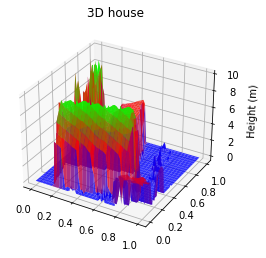

Elapsed time: 0.4422 seconds


In [74]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

@Timer(name="decorator")
def basic_3Dplot(dem=dem):
    
    ny, nx = dem.shape
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    dem3d=ax.plot_surface(xv,yv,dem,cmap='brg', linewidth=0, alpha=0.8)
    ax.set_title('3D house')
    ax.set_zlabel('Height (m)')
    plt.show()
    
basic_3Dplot(dem)